Devin Short 
30 June 2023 
shortda@uw.edu

This is a tutorial demonstrating how to explore data parsed out of the catalogues. The idea is to understand what kind of content we've generated, get a feel for how well our current tools are working, and try improving them. This notebook requires functions from `reporting.py`, currently living in the scripts directory of the github repository.

Let's import some packages and set parameters we'll use below.

In [64]:
import pandas as pd
import re

pd.set_option('display.max_colwidth', 500)

# If you're running this notebook from a directory that doesn't contain
# reporting.py you'll either need to edit the following line to reflect
# the relative location of the reporting module or copy reporting.py
# into the current directory
from reporting import histogram_strings_by_length

# The year determines which issue of the catalogue we're looking at
# across the entire notebook
year = 16

## <u>Summarizing data with histograms</u>

One way to start is by looking at the number of characters in all entries parsed out of one year of the catalogue. Most good entries are going to have similar lengths because they display similar data. Extremely short entries are probably fragments created by OCR errors and some extremely long entries will be multiple entries the code we're using failed to split apart.

We can get an overview by creating a histogram of the entry lengths. A histogram shows a series of bins on the bottom axis and the number of objects falling into each bin on the vertical axis. In this case I've created bins 5 characters wide, so each bar in the plot below shows the number of entries 0-5 characters long, 5-10 characters long, etc.

I've also created parameters to examine "underflow" and "overflow" regions of the histogram. Underflow and overflow counts in a histogram refer to objects that are irrelevant for some reason. In many cases a histogram will have a single underflow or overflow bin that aggregates everything outside the region of interest, but I've included the full histogram here and shaded the outflow regions.

total number of strings: 12620
number of strings shorter than 30 characters: 81, 0.6%
number of strings within outflow limits: 12468
number of strings longer than 300 characters: 71, 0.6%


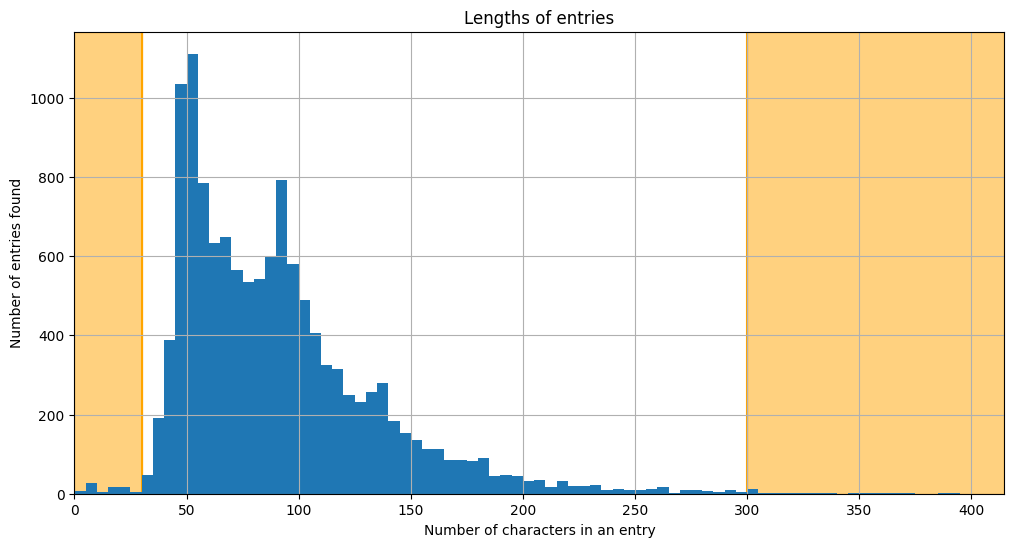

In [65]:
path = f'../entries/clean_entries/entries_19{year}.csv'

# Run this cell and then play around here by adding bins=20 to the
# list of arguments in the call to histogram_strings_by_length below.
# Then try bins=range(400).
# You can change the outflow boundaries by adding underflow_lim or
# overflow_lim to the list of arguments and setting them to integers.
# The default values are underflow_lim=30, overflow_lim=300.
hist_results = histogram_strings_by_length(
    path,
    show_over_under=True,
    drop_nulls=True
)

You can get some idea of what's happening with different output data by examining different sets of entries. Try changing `clean_entries` to `full_entries` in the path above. Notice that the numbers of entries in each section of the histogram, reported above the plot, are different for the two data sets; clearly the existing code does more than identify short or long entries and drop them to transform "full" entries to "clean" entries. 

Looking at the shape of the histogram, you'll see there's a large peak around 50 characters, but then there are smaller peaks at about 90 characters and 140 characters. If you set `bins=range(400)` in the call to `histogram_strings_by_length` above, you'll see those secondary peaks are still present with higher resolution binning. How might we find out what causes that structure?

Let's start by viewing some of the entry strings.

In [66]:
# Get the clean entries from a csv file. Squeeze the result to convert
# the single-column dataframe into a series.
path = f'../entries/clean_entries/entries_19{year}.csv'
clean_entries = pd.read_csv(path, header=None).squeeze()

# Drop null values
clean_entries = clean_entries.dropna()

# Get the length of each entry string
lengths = clean_entries.map(len)

# Get entry strings around the center of the largest peak
first_peak = clean_entries.loc[(lengths > 47) & (lengths < 53)]

# Get entries in the second peak
second_peak = clean_entries.loc[(lengths > 89) & (lengths < 96)]

# Get entries in the third peak
third_peak = clean_entries.loc[(lengths > 134) & (lengths < 140)]

# View a random sample of values in each peak
print(first_peak.sample(20), '\n\n')
print(second_peak.sample(20), '\n\n')
print(third_peak.sample(20))



9836        Secret sympathy, Pendered (M. L.) 6s, net May 16
4385      Girl Crusoes, Strang (Mrs. H.) IS. 3d, net July 16
4595      Great maze, &c., Hagedorn (H.) 5$, 6d. net Apr. 16
11679     War: In the field, Dupont (M.) 35. 6d. net Mar, 16
4235       Geography, Junior, Herbertson (A. J.) 25. Oct. 16
6685        Machine, The, Spender (H. F.) 58. net....Oct. 16
351       Analytical reagents, White (E.) is, net .. July 16
8079        On active service, Owen (A. H.) 6d. net. Nov. 16
1552      Buddhism, Chinese, Edkins (J.) 78. 6d. net Jan. 16
3113       Don, the runaway dog, Barnum (R.) 28. net Oct. 16
6218       Leatherface, Orczy (Baroness) 5s. net ....Aug. 16
6846      Man, Arboreal, Jones (F. W.) 8s. 6d. net.. Oct, 16
10243       Some Cornish folk, Hocking (S.) 1od. net Feb. 16
3214      Early blossoms, Hickley (A. R. P.) is. net Sep. 16
1281     Boone, Daniel, Gulliver (L.) 25. net ...... July 16
4610        Greater power, Thorne (G.) Is. 6d. net ..Feb. 16
9191      Recruits, Rapi

Run the previous cell several times, examining the output carefully each time. Are there clear differences in the contents of the entries from each peak? Can they be explained by reasonable features of a real data set or do you think the structure in the histogram is a result of bad parsing?

I think we can draw three conclusions here:

1. The largest peak is the easiest to explain: title-first entries, which only contain the book title, author name, price, and month of publication, are frequently about 50 characters long. There are of course a huge number of title-first entries much longer than that, and the other two peaks are sitting on top of a long tail from the title-first peak.
2. The second peak looks like it consists mostly of author-first entries for single-author, single-title books.
3. The third peak is the most complicated. I see books that have both multiple authors and long subtitles, as well as entries that have additional information like a series name, such as `(Langham bibelots, No. 10.)`, or a note about translation, for instance `English version by A. W. Verrall.`

If you want an exercise to try working with the data yourself and to follow up on my interpretation above, figure out a way to histogram the shorter title-first entries separately from the longer author-first entries. If you don't know how to start, try this:

1. Make a regular expression that searches for a sequence of capital letters. This won't be a perfect distinction, but the author-first entries usually have a publisher's name in all caps and the title-first entries don't.
2. Use the regular expression to put entries with words in all caps in one pandas series and entries without words in all caps in another.
3. Calculate the lengths of each element in each series and store them in two different series.
4. Create histograms by using the method `.hist(bins=range(0, 400, 3))` on both series of lengths.
5. Play around with the bin width (the third argument in the range function) and see how the features in each histogram change.

You can refer to the last two code cells in this notebook to see an example of a similar process.

If my interpretation above is mostly right then you should see a peak at 50 characters with a long tail to the right in one histogram and a smaller but very similarly shaped peak at about 90 characters in the other (I expect the second peak to have a shorter tail on the left as well). I haven't tried this, so if you do you should let me know what's going on with that third peak - is it present in both histograms? 

## <u>Testing new methods</u>

Some entries in the third peak reveal a flaw in our current approach to splitting the entries: some lines in the catalogue aren't part of an entry. These lines have the form `<author name> see <author name>`, suggesting a reader looking up one author might actually be looking for someone else. The code we're using assumes entries end with an OCR line ending in `12`. It doesn't handle the lines pointing from one author to another, so those lines usually get tacked onto the front of the following entry. The current code does sometimes parse these author-to-author lines as individual entries. It looks to me like this happens when they are the last OCR'd line on a page.

I figured that out by repeatedly looking at samples generated by the next cell and then searching the Hathi Trust online PDF for the contents of author-to-author lines that appeared separate from a full entry.

In [67]:
author_to_author_entries = clean_entries.loc[
    clean_entries.str.contains(' see ')
]

# python interprets two strings on successive lines as a single string
# so it's easier to read long strings in source code.
print(
    'number of entries containing " see ":'
    f' {author_to_author_entries.size}\n\n'
)

author_to_author_entries = clean_entries.loc[
    clean_entries.str.contains(' see ') & (lengths < 120)
]
author_to_author_entries.sample(20)

number of entries containing " see ": 287




4971     Heyman (S. Reid-) see Reid-Heyman. Hiawatha, Dramatized scenes from Longfellow's, Wyngate (V.) 28. 6d. pet ...Sep. 16
6094                                             L. (A.S.) see Jones (Mrs. H.). L. (O. E.)-Something. Pr. for author ..Oct. 16
2003                          Chekhoff, Chekhov, see also Tchehov; Tchekhov. Chelkash, stories, Gorky (M.) is. net ....July 16
9969                    Sharples (Alexander) see Barnes (J. R.) and Sharples. Sharrow, Hutten (Baroness von) is. net.. Apr. 16
10159     Smith (Sheila Kaye-) see Kaye-Smith. Smith (Stephen)—Who is insane? Cr. 8vo. 74 x 51, 5s. 6d. net MACMILLAN, Feb. 16
8834           Potts (W. A.) see Shuttleworth (G. E.) and Potts. Poultry : Commer. egg farming, Hanson (S. G.) 18. net June 16
9784                                Scudamore (Frank) see Maude (F. N.) and Scudamore. Sculpture, Greek. 35. 6d. net. .Aug. 16
2112                 Chouville (L.) see Glehi (L. C. von) and others. Christ and sorrow, Moule (H. C. G.) 13., 

If you can come up with a way to identify those author-to-author lines and separate them from the entries, you'll improve our data set. That's going to be pretty difficult though, so let's start with something easier.

Have a look at a sample of the longest entries:

In [68]:
clean_entries.loc[(lengths > 325) & (lengths < 350)]

663       " Athenaum (The)” Subject index to periodicals, Aulnoy (Madame d')-The Palace of peaceful 1915. 12;X 10, pp. 365, 428. net; separate pleasures. Ed. by Elsie J. Crosfield. Cr. 8vo. class lists, various prices, subscrip.," 1os. 60. 74 x 54, pp. 64, swd. 3d. (“A.L.” Bright story net per set ... THE ATHENÆUM," Nov. 16 readers). .E. J. ARNOLD, Jan. 16
1723                        Cambridge University-Local exam., 1915 : 58th annual rpt. of the Local Exam. and Lectures Syndicate, w. supp. tab. for home centres, Dec. 1915, and lists in order of merit of the senior and junior students at all centres who obtain the mark of distinction in each subject. Demy 8vo., 8} x 51, pp. 228, 25. CAMB. UNIV. PR., Apr. 16
6284                     Leighton (J. and J.)-Early printed books, arranged in order of presses, accord. to Proctor's Index. Pt. 2, Italy (Foligno to Arezzo), Switzerland, and addenda. W. indexes to authors, printers, &c., and subjects, binders and owners, in Pts. 1 and 2. 8vo. IS.

A substantial number of long entries have a date that should mark a point to split entries that was missed for some reason. Reviewing a few samples in the previous cell, I see at least three cases that need to be handled:
1. OCR mistakes, like `I2` or `1z` or `iz` rather than `12`
2. Books published in 1911 and listed in this catalogue (our code assumes `12` is part of the entry delimiter)
3. Entries with apparently well-formed 1912 dates that the current code failed on. For example, entry `14814` appears to be three entries separated by two 1912 dates that were skipped over for reasons I don't understand yet. Run the next cell to see it.

In [69]:
clean_entries[12000]

'Weapon unsheathed, Wilson (T. W.) is. 3d. net Dec. 16'

The first two cases are relatively easy to handle. Let's start by finding the regular expressions our code uses to split entries apart and build on that to improve the current process. That code is documented in `Parsing_ECB_1912_wi23.ipynb`, currently living in the `scripts` directory of the github repository. In the section "Splitting the Text into Entries" in that notebook, I find the following process:

In [70]:
# ALL CODE IN THIS CELL IS ADAPTED FROM Parsing_ECB_1912_wi23.ipynb

# read the Hathi Trust OCR into memory
with open(f'../princeton_years/ecb_19{year}.txt', encoding='utf8') as f:
    ocr_full_text = f.read()

# Separate main text from the front matter of the catalogue (note the
# string called ocr_main_text still has the back matter attached until
# a later step)
# Note python allows multiple assignment: the split operation below
# creates a two-element list whose elements are then assigned to two
# different variables
ocr_front_matter, ocr_main_text = re.split(r'centimetres', ocr_full_text)

appendix_pattern = (
    r"APPENDIX\nLEARNED SOCIETIES, PRINTING CLUBS, &c., "
    r"WITH LISTS OF THEIR\nPUBLICATIONS, 1916"
)

# Separate main text from the back matter of the catalogue
ocr_main_text, ocr_back_matter = re.split(appendix_pattern, ocr_main_text)

# Make a regular expression to capture headers at the top of each
# catalogue page
header_capital_letters = r"^(?:[A-Z\-\'\sÈ]+)"
header_pattern = r"^#(?s:.*?){}(?s:.*?){}(?s:.*?){}$".format(
    header_capital_letters, header_capital_letters, header_capital_letters
)

# Split the main text into pages and strip the headers. According to
# Parsing_ECB_1912_wi23.ipynb this method fails to remove six headers.
pages = [
    re.sub(header_pattern, '', page, flags=re.M)
    for page in ocr_main_text.split('\f')
]

# Now find all lines ending in 12 and insert a token to split on
entries_by_page = [
    re.sub(r'(\W16\.?$)', '\\1<ENTRY_CUT>', page, flags=re.M)
    for page in pages
]

# Split on the token to create a list of lists where each element is
# a list of entries on an individual page
entries_by_page = [
    re.split(r'<ENTRY_CUT>', page, flags=re.M)
    for page in entries_by_page
]

print(f'total entries: {sum([len(p) for p in entries_by_page])}')

total entries: 14733


Now let's test a new regular expression for splitting entries 

In [71]:
# This cell assumes we're looking at the 1912 catalogue; try changing
# this code (and the year parameter in the first code cell of the
# notebook) to catch OCR mistakes for a different year.

# create a list of possible values the OCR software might have created
# when it ran into an 11 or 12 on the page
ocr_interpretations_of_12 = [
    '12',
    'i2',
    'I2',
    '1z',
    '1Z',
    'iz',
    'Iz',
    'iZ',
    'IZ'
]
ocr_interpretations_of_11 = [
    '11',
    'i1',
    'I1',
    '1i',
    '1I',
    'ii',
    'Ii',
    'iI',
    'II'
]
ocr_interpretations_of_16 = [
    '16',
    'i6',
    'I6',
    '15',
    'i5',
    'I5',
    '18'
]
terminators = ocr_interpretations_of_16

# modify the existing regex with our new options
entry_terminator_regex = r'(\W({})\.?$)'.format('|'.join(terminators))

# get a new set of entries the same way as above, but using the new
# regular expression
new_entries_by_page = [
    re.sub(entry_terminator_regex, '\\1<ENTRY_CUT>', page, flags=re.M)
    for page in pages
]
new_entries_by_page = [
    re.split(r'<ENTRY_CUT>', page, flags=re.M)
    for page in new_entries_by_page
]

print(f'total entries: {sum([len(p) for p in new_entries_by_page])}')


total entries: 14888


OK, we might have found 157 entries that weren't caught with the previous splitting expression, meaning we might have gained 314 entries that were either not present or invalid in the previous data set. Let's see if that's really what happened.

number of new entries: 267


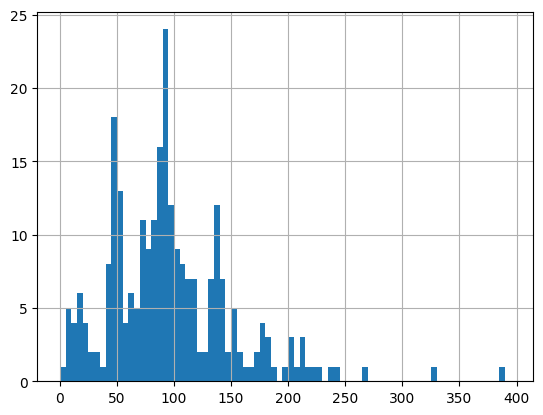

In [72]:
# It can be much more efficient to do things like check if elements in
# one sequence exist in another using pandas objects rather than the
# standard python library, so I flatten the lists of lists of entries
# into pandas series containing all the entries.
old_entries = pd.Series(
    [e for page in entries_by_page for e in page],
    dtype=pd.StringDtype()
)
new_entries = pd.Series(
    [e for page in new_entries_by_page for e in page],
    dtype=pd.StringDtype()
)

# strip nonprinting characters and replace all newlines in each entry
# with spaces
old_entries = old_entries.str.strip()
new_entries = new_entries.str.strip()
old_entries = old_entries.str.replace('\n', ' ')
new_entries = new_entries.str.replace('\n', ' ')

# Get new entries that don't exist in the old set
new_entries = new_entries.loc[~new_entries.isin(old_entries)]

print(f'number of new entries: {len(new_entries)}')

# plot a histogram of lengths of the new entries
fig2 = new_entries.map(len).hist(bins=range(0, 400, 5))

The histogram we started with covers nearly 20,000 entries. Here we have only 300, but the plot generated in the previous cell already looks extremely similar to the one at the top of the document. This means we can probably assume the entries we've produced here are just as good as the rest of the entries we're already capturing. Probably! I haven't actually looked at the new entries in detail, but it's 0200 and I need to finish this up.

## <u>Wrapping up</u>

The goal here was to demonstrate how to play around with the data and the code for our summer project. The general method I followed was something like the following:
1. Get some kind of overview of the output from our current parsing operations. I went with the size of the strings but there are all kinds of ways to do this. You could think about features of strings that have words in all caps and compare them to strings that don't have capitalized words (publishers in the author-first entries are almost always capitalized). You could start by exploring the dataframes, where the strings have been parsed out into specific fields, rather than thinking about whole entries. Explore the results we have and find something you think is interesting. If you can't think of a way to use that feature to explore the data, run it by one of your colleagues and see what they think. Your team is always your best asset!
2. Use that view of the data to characterize what's working and what isn't. In this case it was clear that unreasonably short or long strings were going to have some errors, so I was able to look at those entries to see where there might be problems in the existing process.
3. Find out which part of the existing code is relevant for the feature you're interested in. This part is probably going to be hard if you haven't had a much experience with programming. If it isn't obvious how to proceed after you've had a look at some of the scripts, ask me or Anna how to do what you want to do.
4. See if you can modify the code to get different results.
5. Use the same overview process you started with to compare your new result with the old one.
